In [1]:
# Goal: Estimate the peak pseudo-bolometric magnitude and luminosity

In [26]:
import sys, tqdm
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import seaborn
from astropy.modeling import models, fitting
import pandas as pd
import scipy.integrate as integrate

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.lc.observables as observables
import snelib19odp.lc.bolometric as bolometric
import snelib19odp.utils as utils

In [3]:
ds = dataset.load_dataset('SN2019odp_phot')
bolometric_method = 'lyman'

In [4]:
bolo = ds.get_bolometric(bolometric_method)

100%|██████████| 1000/1000 [00:09<00:00, 103.65it/s]

58734.96192997451
0.5271707212035956


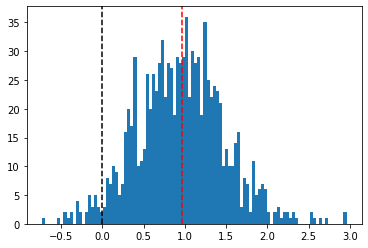

In [16]:
# estimate the peak phase
N = 1000
peak_t = np.empty(N, dtype=np.float)
trange = 10
#t_grid = ds.transient.prior_t0 + np.linspace(-trange, trange)
for i in tqdm.trange(N):
    t_grid = ds.transient.prior_t0 + np.sort(np.random.uniform(-trange, trange, size=50))
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['no-correlated-error'])
    # find the brightest data point (magnitude -> smallest numeric value)
    max_idx = np.argmin(lc)
    peak_t[i] = t_grid[max_idx]
    #plt.plot(t_grid, lc)
mean_peak_t = np.nanmedian(peak_t)
print(mean_peak_t)
print(np.nanstd(peak_t))
plt.hist(peak_t - ds.transient.prior_t0, bins=100)
plt.axvline(0, ls='--', color='black')
plt.axvline(mean_peak_t - ds.transient.prior_t0, ls='--', color='red')

100%|██████████| 1000/1000 [00:10<00:00, 92.97it/s]


58736.37100670299
0.5815407297372058
2.371006702989689


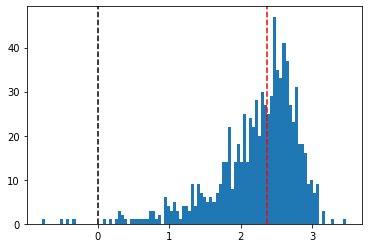

In [16]:
# estimate the peak phase by fitting
N = 1000
peak_t = np.empty(N, dtype=np.float)
trange = 10
#t_grid = ds.transient.prior_t0 + np.linspace(-trange, trange)

# setup the model
line_mod = models.Gaussian1D(amplitude=-17.5, mean=0, stddev=1)

t_grid2 = np.linspace(-trange, trange)

for i in tqdm.trange(N):
    t_grid = ds.transient.prior_t0 + np.sort(np.random.uniform(-trange, trange, size=10))
    lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['no-correlated-error'])
    # fit a function to it
    fit = fitting.LevMarLSQFitter()
    line_init = models.Gaussian1D(bounds={'mean': (-10, 10)})
    fitted_line = fit(line_init, t_grid-ds.transient.prior_t0, -lc)
    fit_result = fitted_line.mean+ds.transient.prior_t0
    max_idx = np.argmin(lc)
    peak_t[i] = fit_result
    #plt.plot(t_grid2, fitted_line(t_grid2))
    #plt.plot(t_grid-ds.transient.prior_t0, -lc)
    #break
peak_t[np.abs(peak_t-ds.transient.prior_t0) > 5] = np.nan
mean_peak_t = np.nanmedian(peak_t)
print(mean_peak_t)
print(np.nanstd(peak_t))
print(mean_peak_t - ds.transient.prior_t0)
plt.hist(peak_t - ds.transient.prior_t0, bins=100)
plt.axvline(0, ls='--', color='black')
plt.axvline(mean_peak_t - ds.transient.prior_t0, ls='--', color='red')

100%|██████████| 1000/1000 [00:08<00:00, 123.06it/s]


Mean:  -17.90732883372426
Std:  0.20644835901887654
Percentiles Err:  [-0.21525491  0.20087218]


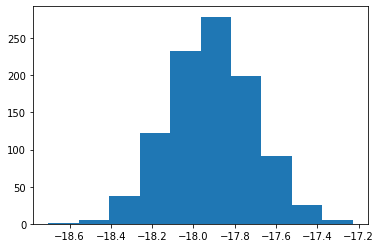

In [19]:
# now sample peak time including all correlated uncertainties
N = 1000
peak_mag = np.empty(N, dtype=np.float)
for i in tqdm.trange(N):
    peak_mag[i] = ds.sample_abs_lc(method=bolometric_method, t_grid=np.array([mean_peak_t]), tweaks=['correleated-error'])
mean_peak = np.median(peak_mag)
std_peak = np.std(peak_mag)
print('Mean: ', mean_peak)
print('Std: ', std_peak)
print('Percentiles Err: ', np.percentile(peak_mag, [15.9, 84.1]) - mean_peak)
plt.hist(peak_mag);

Mean:  43.84332368730514
Std:  8.56096672508824
Percentiles Err:  [-7.40531808  9.6137811 ]


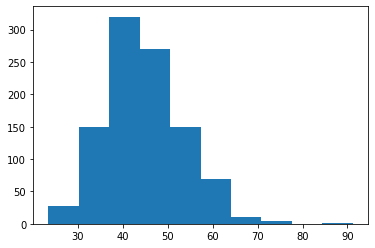

In [22]:
# convert to luminosities
lums = 3.828e33 * 10** ((4.74 - peak_mag)/2.5)/1e41
mean_lums = np.median(lums)
std_lums = np.std(lums)
print('Mean: ', mean_lums)
print('Std: ', std_lums)
print('Percentiles Err: ', np.percentile(lums, [15.9, 84.1]) - mean_lums)
plt.hist(lums);

# Integrated luminosity

In [11]:
# first most simplistic attempt

# get the time-range where the bolometric lc is valid
time_valid = bolo.validity_range

# utility function to sample the luminosity at certain times
def get_lums(t_grid):
    mags = bolo.sample(t_grid, tweaks=set(['sample-lyman-scatter', 'sample-correlated']))
    return utils.convert_luminosity(mags)

t_grid = np.linspace(time_valid[0], time_valid[1], 300)

N = 100

int_lums = np.empty(N)
for i in range(N):
    lums = get_lums(t_grid)
    int_lums[i] = np.trapz(lums, t_grid*24*3600)
plt.hist(int_lums)

(array([ 6.,  9., 10., 20., 22., 12., 12.,  6.,  2.,  1.]),
 array([1.48166884e+49, 1.65952088e+49, 1.83737292e+49, 2.01522496e+49,
        2.19307700e+49, 2.37092904e+49, 2.54878108e+49, 2.72663312e+49,
        2.90448516e+49, 3.08233719e+49, 3.26018923e+49]),
 <BarContainer object of 10 artists>)

In [46]:
# now do it properly with different methods

## global params
N = 100

## calculate some params
# get the time-range where the bolometric lc is valid
time_valid = bolo.validity_range

fixed_grids = [50, 100, 200]
random_grids = [50, 100]
#quad_orders = [5,10,15,25]
quad_orders= []

# pre-compute the quad time grids
quad_grids = {}
for n in quad_orders:
    used = []
    def wrapper(t):
        used.extend(t/24/3600)
        #print(t)
        return get_lums(t/24/3600)
    integrate.fixed_quad(wrapper, a=time_valid[0]*24*3600, b=time_valid[1]*24*3600, n=n)
    print(used)
    quad_grids[n] = np.sort(used)

rows = []

for _i in range(N):
    # fixed grid
    for n_days in fixed_grids:
        t_grid = np.linspace(time_valid[0], time_valid[1], n_days)
        lums = get_lums(t_grid)
        int_lums = np.trapz(lums, t_grid*24*3600)
        rows.append({'t_grid': 'fixed(%d)' % n_days, 'int_method': 'trapz', 'int_lums': int_lums, 'bolo_method': 'lyman'})
        
        int_lums = integrate.simps(lums, t_grid*24*3600, even='last')
        rows.append({'t_grid': 'fixed(%d)' % n_days, 'int_method': 'simpson', 'int_lums': int_lums, 'bolo_method': 'lyman'})
    
    # random grids
    for n_days in fixed_grids:
        t_grid = np.sort(np.random.uniform(time_valid[0], time_valid[1], size=n_days))
        lums = get_lums(t_grid)
        int_lums = np.trapz(lums, t_grid*24*3600)
        rows.append({'t_grid': 'random(%d)' % n_days, 'int_method': 'trapz', 'int_lums': int_lums, 'bolo_method': 'lyman'})
    
    # Gaussian Quadrature
    for n in quad_orders:
        t_grid = quad_grids[n]
        lums = get_lums(t_grid)
        def getter(tgrid):
            ret = np.empty_like(tgrid)
            for i in range(len(tgrid)):
                t = tgrid[i]
                idx = np.abs(t_grid-t).argmin()
                ret[i] = lums[idx]
            return ret
        int_lums = integrate.fixed_quad(getter, a=time_valid[0]*24*3600, b=time_valid[1]*24*3600, n=n)
        rows.append({'t_grid': 'quad(%d)' % n, 'int_method': 'quad', 'int_lums': int_lums[0], 'bolo_method': 'lyman'})
        
df = pd.DataFrame.from_records(rows)
df

t_grid int_method      int_lums bolo_method
0      fixed(50)      trapz  1.536832e+49       lyman
1      fixed(50)    simpson  1.546160e+49       lyman
2     fixed(100)      trapz  2.421002e+49       lyman
3     fixed(100)    simpson  2.424662e+49       lyman
4     fixed(200)      trapz  2.170326e+49       lyman
..           ...        ...           ...         ...
895   fixed(200)      trapz  1.632571e+49       lyman
896   fixed(200)    simpson  1.632674e+49       lyman
897   random(50)      trapz  2.129483e+49       lyman
898  random(100)      trapz  1.183207e+49       lyman
899  random(200)      trapz  2.702208e+49       lyman

[900 rows x 4 columns]

In [48]:
seaborn.stripplot(data=df, x='int_lums', y='t_grid', hue='int_method', dodge=True)

<AxesSubplot:xlabel='int_lums', ylabel='t_grid'>

In [49]:
seaborn.boxplot(data=df, x='int_lums', y='t_grid')

<AxesSubplot:xlabel='int_lums', ylabel='t_grid'>

In [50]:
df.groupby(['t_grid']).quantile([0.15899, 0.5, 0.841])

int_lums
t_grid                           
fixed(100)  0.15899  1.689120e+49
            0.50000  2.122126e+49
            0.84100  2.619846e+49
fixed(200)  0.15899  1.715093e+49
            0.50000  2.077505e+49
            0.84100  2.576690e+49
fixed(50)   0.15899  1.781726e+49
            0.50000  2.148225e+49
            0.84100  2.565398e+49
random(100) 0.15899  1.714252e+49
            0.50000  2.078758e+49
            0.84100  2.489397e+49
random(200) 0.15899  1.793776e+49
            0.50000  2.149846e+49
            0.84100  2.484998e+49
random(50)  0.15899  1.554864e+49
            0.50000  1.959745e+49
            0.84100  2.424644e+49

In [43]:
integrate.simps?

In [51]:
time_valid

(58717.3948958, 59116.06843328704)